In [1]:
import PIL
import math
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageFilter
from torchvision import transforms
from torch import save
import h5py
import numpy as np

import time
import random
import json
import csv
import pathlib
from os import listdir
from os.path import isfile, join

all_settings = {
    'kanji' : {
        'script_name' : 'kanji',
        'filename':'./Symbols/kanji_array.json',
        'fonts' : [
            {'font_name':"meiryo.ttc", 'offset':-0.15}, #Requires japanese language to be added as a language in windows options
            {'font_name':"yumin.ttf", 'offset':0},
            {'font_name':"YuGothB.ttc", 'offset':0},
            {'font_name':"./Fonts/DelaGothicOne-Regular.ttf", 'offset':-0.25}
        ]
    },
    
    'hangul' : {
        'script_name' : 'hangul',
        'filename':'./Symbols/hangul_array.json',
        'fonts' : [
            {'font_name':'malgunbd.ttf', 'offset':-0.2},
            {'font_name':'malgun.ttf', 'offset':-0.2},
            {'font_name':'malgunsl.ttf', 'offset':-0.2},
        ]
    }
}
            
settings = all_settings['kanji']
#settings = all_settings['hangul']


In [103]:
symbol_array = []
with open(settings['filename'], mode='r',encoding="utf-8") as f:
    symbol_array = json.load(f)

def createImageRotations(pixelSize=64,symbol=u"魔",font=None, yBaseOffset=0,key=-1,foreground=(0,0,0,255),background=(255,255,255),angle=0,seed=0) -> Image:
    random.seed(seed)
    
    if font == None:
        font = ImageFont.truetype("meiryo.ttc", 40)
    
    fontSize = font.size
    
    #randXOffset = random.randrange((font.size//4) + 1) - font.size//8
    #randYOffset = random.randrange((font.size//4) + 1) - font.size//8
    
    randXOffset = random.randrange(17)-8
    randYOffset = random.randrange(17)-8
    
    fontOffsetX = (pixelSize-fontSize)//2 + randXOffset
    fontOffsetY = yBaseOffset*fontSize +(pixelSize-fontSize)//2 + randYOffset
    
    perturbationOffset = fontSize
    
    
    
    image1 = Image.new(mode='LA', size = (pixelSize,pixelSize), color=(255,0))
    background1 = Image.new(mode='L', size = (pixelSize,pixelSize), color=background)
    
    draw1 = ImageDraw.Draw(image1)
    
    draw1.text((fontOffsetX,fontOffsetY), symbol, foreground, font=font)
    sampling = PIL.Image.Resampling.BICUBIC
    
    image_rot = background1.copy()
    image_rot.paste(image1.rotate(angle,sampling), (0, 0), image1.rotate(angle,sampling).split()[-1])
    
    #Add perturbations
    
    if random.randrange(2) == 0:
        #print("Success")
        
        decider = random.randrange(4)
        x = -1 if decider==0 else (1 if decider==1 else 0)
        y = -1 if decider==2 else (1+(yBaseOffset*0.7) if decider==3 else 0)
        
        n_symbol = random.randrange(len(symbol_array))
        symbolPerturbation = symbol_array[n_symbol]
        
        image2 = Image.new(mode='LA', size = (pixelSize,pixelSize), color=(255,0))
        draw2 = ImageDraw.Draw(image2)
        draw2.text((fontOffsetX + x*perturbationOffset , fontOffsetY + y*perturbationOffset), symbolPerturbation, foreground, font=font)
        image_rot.paste(image2.rotate(angle,sampling), (0, 0), image2.rotate(angle,sampling).split()[-1])
    
    if random.randrange(2) == 0:
        max_rad = 2 if fontSize >= 40 else 1
        gauss_rad = random.randrange(max_rad)+1
        image_rot = image_rot.filter(ImageFilter.GaussianBlur(radius = gauss_rad))
    
    #image_rot.show()
    return image_rot

1


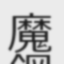

In [97]:
tempFont = ImageFont.truetype("meiryo.ttc", 45)
T = transforms.ToTensor()
reverseT = transforms.ToPILImage()
img1 = createImageRotations(
    pixelSize=64,
    symbol=u"魔",
    font=tempFont,
    yBaseOffset=-0.15,
    key=-1,
    foreground=(30,255),
    background=(235),
    angle=0,
    seed=4
    #4 has a symbol lower down
    #13 has a symbol on the right
)
#print(np.asarray(img1).astype(np.ubyte))
img1
#(255*np.asarray(img1)).astype(np.byte)

In [105]:
def createImage2(file, pixelSize=64, symbol=u"魔", key=-1, debug=False):
    #Do it more or less 150 times per symbol
    num_variations = 150
    
    fonts = [
        {
        'font_name' : settings['fonts'][index]['font_name'], 
        'offset' : settings['fonts'][index]['offset']
        } 
        for index in range(len(settings['fonts']))
    ]
    n_fonts = len(fonts)

    num_iter = 0
    for i in range(num_variations):

        num_iter = i+1

        #Colors
        fore_color = random.randrange(100)
        back_color = 255 - random.randrange(50)
        invert = random.randrange(2)
        temp = fore_color
        fore_color = invert*back_color + (1-invert)*fore_color
        back_color = invert*temp       + (1-invert)*back_color

        #Fonts
        size = random.uniform(0.6, 1.25)
        fontSize = math.floor(size*pixelSize)
        i_font = random.randrange(n_fonts)
        fontName = fonts[i_font]['font_name']
        fontYOffset = fonts[i_font]['offset']
        font = ImageFont.truetype(fontName, fontSize)

        rotation = random.uniform(-10.0, 10.0)

        image1 = createImageRotations(
            pixelSize=pixelSize,
            symbol=symbol,
            font=font,
            yBaseOffset=fontYOffset,
            key=key,
            foreground=(fore_color,255),
            background=(back_color),
            angle=rotation,
            seed=(key+1)*num_iter
        )

        np_array = np.asarray(image1).astype(np.ubyte)

        isEval = random.randrange(4)==0
        group = 'evaluation_group' if isEval else 'training_group'

        dataset = f[group]['dataset']
        labels = f[group]['labels']

        if not dataset.attrs['empty']:
            dataset.resize(1+dataset.shape[0],axis=0)
            labels.resize(1+labels.shape[0],axis=0)

        dataset.attrs['empty'] = False
        labels.attrs['empty'] = False
        dataset[-1] = np_array
        labels[-1] = key
        
        if debug:
            filename = u"./Image_set_debug/"+str(key) +"_"+ symbol +"_"+ str(num_iter) +"_"+ font.getname()[0] +"_"+ font.getname()[1]
            image1.convert("L").save(filename+".jpg")
    

In [107]:

picturesAsTensors = True
pixelSize = 64
debug = False

with open(settings['filename'], mode='r',encoding="utf-8") as f:
    symbol_array = json.load(f)
    random.seed(420)
    
    with h5py.File('image_set_' + settings['script_name'] + '.hdf5', mode='w') as f:
    
        train_group = f.create_group("training_group")
        eval_group = f.create_group("evaluation_group")
        t_set = train_group.create_dataset("dataset", dtype=np.ubyte, data=np.zeros([1,pixelSize,pixelSize]),maxshape=(None, pixelSize, pixelSize))
        t_lab = train_group.create_dataset("labels", dtype=np.intc, data=np.zeros([1,1]),maxshape=(None,1))
        e_set = eval_group.create_dataset("dataset", dtype=np.ubyte, data=np.zeros([1,pixelSize,pixelSize]),maxshape=(None, pixelSize, pixelSize))
        e_lab = eval_group.create_dataset("labels", dtype=np.intc, data=np.zeros([1,1]),maxshape=(None,1))
        
        t_set.attrs['empty'] = True
        t_lab.attrs['empty'] = True
        e_set.attrs['empty'] = True
        e_lab.attrs['empty'] = True
        
        start = time.time()
        for index in range(len(symbol_array)):
            
            symbol = symbol_array[index]
            key = index
            createImage2(file=f, pixelSize=pixelSize, symbol=symbol, key=key, debug=debug)
            if index%50==49:
                end = time.time()
                ratio = index/len(symbol_array)
                dt = end-start
                expected_time = math.floor(dt*((1-ratio)/ratio))

                percent = 100*ratio
                percent = math.floor(100*percent)/100
                print(str(percent)+"% of pictures generated. Estimated time left : " 
                      + str(expected_time//60) + "m " + str(expected_time%60) + "s")
            
print("100% of pictures generated.")

1.55% of pictures generated. Estimated time left : 22m 42s
3.14% of pictures generated. Estimated time left : 22m 16s
4.73% of pictures generated. Estimated time left : 21m 56s
6.31% of pictures generated. Estimated time left : 21m 46s
7.9% of pictures generated. Estimated time left : 21m 36s
9.49% of pictures generated. Estimated time left : 21m 38s
11.08% of pictures generated. Estimated time left : 22m 16s
12.67% of pictures generated. Estimated time left : 21m 42s
14.25% of pictures generated. Estimated time left : 21m 9s
15.84% of pictures generated. Estimated time left : 20m 41s
17.43% of pictures generated. Estimated time left : 20m 14s
19.02% of pictures generated. Estimated time left : 19m 47s
20.6% of pictures generated. Estimated time left : 19m 25s
22.19% of pictures generated. Estimated time left : 19m 0s
23.78% of pictures generated. Estimated time left : 18m 36s
25.37% of pictures generated. Estimated time left : 18m 11s
26.96% of pictures generated. Estimated time left 

In [ ]:
#Used to append stuff to the character lists
"""
with open('./Symbols/kanji_array.json', mode='r',encoding="utf-8") as f:
    symbol_array = json.load(f)
    
    with open('./Symbols/list_kana_shortened.json', mode='r',encoding="utf-8") as f2:
        kana_array = json.load(f2)
        
        set_symbol = {kanji:0 for kanji in symbol_array}
        print(len(set_symbol))
        
        for kana in kana_array:
            set_symbol[kana] = set_symbol.get(kana,0) + 1
        
        print(len(set_symbol))
        
        pairs = json.loads(json.dumps(set_symbol)).items() #weird deep copy + get items list
        
        for pair in pairs:
            if pair[1] == 0:
                del set_symbol[pair[0]]
                
        print(len(set_symbol))
        print(set_symbol)
        new_array = []
        new_array.extend(symbol_array)
        new_array.extend( [pair[0] for pair in set_symbol.items()] )
        
        print(len(new_array))
        
        with open('./Symbols/kanji_array_2.json', mode='w', encoding='utf-8') as f3:
            json.dump(new_array, f3, ensure_ascii=False)
    
"""